##                Mask Rcnn using resnet-101 as backbone

### Let us load the dataset first. We will be using the PennFudan Pedestrian detection dataset

In [1]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2020-01-03 17:13:14--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M   937KB/s    in 52s     

2020-01-03 17:14:06 (1011 KB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2020-01-03 17:14:06--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2020-01-03 17:14:06--
Total wall clock time: 52s
Downloaded: 1 files, 51M in 52s (1011 KB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennF

Lets look at a single image from the dataset

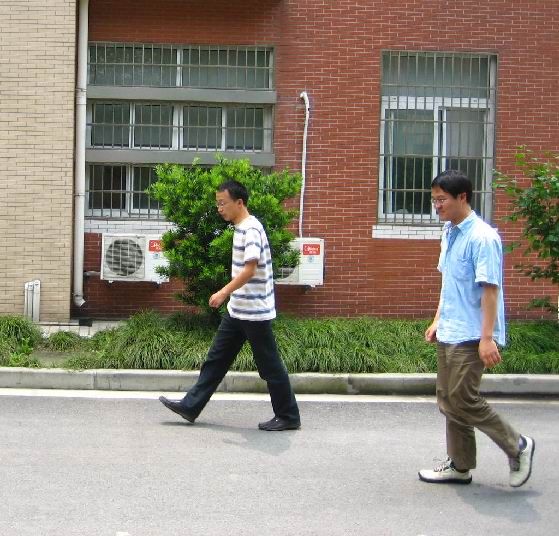

In [2]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

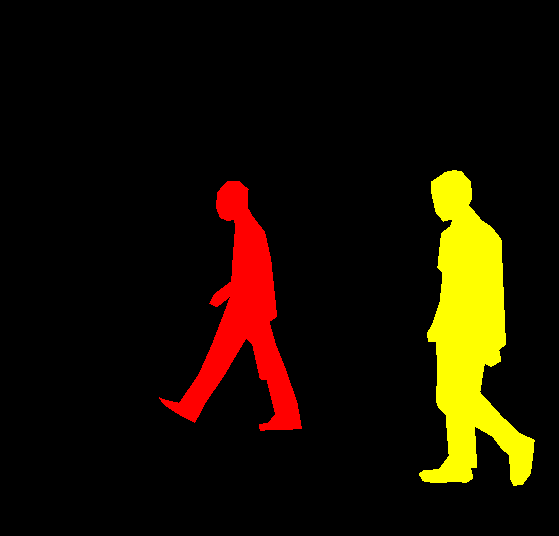

In [3]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

In [0]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7F816F0B66A0>,
 {'area': tensor([35358., 36225.]), 'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]), 'image_id': tensor([0]), 'iscrowd': tensor([0, 0]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

In [14]:
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
 
# load a pre-trained model for classification and return
# only the features
backbone= torchvision.models.vgg16(pretrained=True).features
print(backbone)
backbone.out_channels = 512
 
# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
 
# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)
mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                  output_size=7,
                                                  sampling_ratio=2)
# put the pieces together inside a FasterRCNN model
model = MaskRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler,
                 mask_roi_pool=mask_roi_pooler)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    #model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [16]:
%%shell
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [0]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [0]:
from torch.utils.tensorboard import SummaryWriter

In [21]:
# let's train it for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

    

Epoch: [0]  [  0/120]  eta: 0:02:11  lr: 0.000047  loss: 3.1247 (3.1247)  loss_classifier: 0.6602 (0.6602)  loss_box_reg: 0.0055 (0.0055)  loss_mask: 1.7427 (1.7427)  loss_objectness: 0.6951 (0.6951)  loss_rpn_box_reg: 0.0212 (0.0212)  time: 1.0936  data: 0.2050  max mem: 4444
Epoch: [0]  [ 10/120]  eta: 0:00:29  lr: 0.000467  loss: 2.7516 (2.8961)  loss_classifier: 0.6454 (0.6433)  loss_box_reg: 0.0166 (0.0148)  loss_mask: 1.3860 (1.5134)  loss_objectness: 0.6966 (0.6958)  loss_rpn_box_reg: 0.0280 (0.0288)  time: 0.2710  data: 0.0224  max mem: 4915
Epoch: [0]  [ 20/120]  eta: 0:00:23  lr: 0.000886  loss: 2.3602 (2.5556)  loss_classifier: 0.5962 (0.6055)  loss_box_reg: 0.0164 (0.0153)  loss_mask: 1.0120 (1.1988)  loss_objectness: 0.6925 (0.6941)  loss_rpn_box_reg: 0.0280 (0.0419)  time: 0.1894  data: 0.0036  max mem: 4915
Epoch: [0]  [ 30/120]  eta: 0:00:19  lr: 0.001306  loss: 1.9921 (2.3515)  loss_classifier: 0.5300 (0.5686)  loss_box_reg: 0.0170 (0.0207)  loss_mask: 0.6956 (1.0241) 

In [22]:
# pick one image from the test set
img, tar = dataset_test[3]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
img

tensor([[[0.0588, 0.0627, 0.0627,  ..., 0.1294, 0.1725, 0.2118],
         [0.0588, 0.0627, 0.0588,  ..., 0.1608, 0.2471, 0.3176],
         [0.0588, 0.0588, 0.0549,  ..., 0.1216, 0.1961, 0.2314],
         ...,
         [0.8157, 0.8118, 0.8039,  ..., 0.8392, 0.8431, 0.8471],
         [0.8431, 0.8510, 0.8549,  ..., 0.8588, 0.8627, 0.8667],
         [0.8667, 0.8745, 0.8902,  ..., 0.8784, 0.8784, 0.8824]],

        [[0.0784, 0.0824, 0.0824,  ..., 0.1765, 0.2275, 0.2667],
         [0.0784, 0.0824, 0.0784,  ..., 0.2078, 0.3020, 0.3725],
         [0.0784, 0.0784, 0.0745,  ..., 0.1725, 0.2510, 0.2863],
         ...,
         [0.7098, 0.7059, 0.6902,  ..., 0.7647, 0.7686, 0.7725],
         [0.7529, 0.7490, 0.7490,  ..., 0.7843, 0.7882, 0.7922],
         [0.7843, 0.7922, 0.8000,  ..., 0.7961, 0.8039, 0.8078]],

        [[0.0627, 0.0667, 0.0667,  ..., 0.0902, 0.1294, 0.1686],
         [0.0627, 0.0667, 0.0627,  ..., 0.1216, 0.2118, 0.2745],
         [0.0627, 0.0627, 0.0588,  ..., 0.0941, 0.1608, 0.

#### Lets inspect the Structure of target

In [23]:
tar

{'area': tensor([28028., 30240.,  9735.,  9360.]),
 'boxes': tensor([[ 85.,  14., 183., 300.],
         [175.,  34., 287., 304.],
         [  1.,  45.,  56., 222.],
         [320.,  53., 372., 233.]]),
 'image_id': tensor([135]),
 'iscrowd': tensor([0, 0, 0, 0]),
 'labels': tensor([1, 1, 1, 1]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0,

In [24]:
prediction

[{'boxes': tensor([[  0.0000,  43.0686,  42.1203, 228.2542],
          [ 70.5460,  36.9099, 186.5317, 303.3747],
          [177.4324,  42.8363, 291.9389, 305.3246],
          [306.2998,  36.8736, 377.5421, 236.2376],
          [252.6812,  58.1951, 320.8753, 254.7092],
          [  0.0000,  14.3694,  78.7032, 215.8347],
          [236.4529,  42.0250, 354.7998, 271.8547],
          [104.0070,  35.1584, 235.8346, 286.8057],
          [260.9458, 164.6385, 299.7460, 262.6397],
          [354.4213,  43.5500, 391.5530, 217.4294],
          [134.6754,  43.1289, 205.5466, 250.6608],
          [102.1229,  93.6839, 175.2523, 298.9107],
          [ 17.9582,  43.9531,  65.7536, 171.2134],
          [ 51.0845,  27.7083, 128.6275, 242.5053]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
     

In [0]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

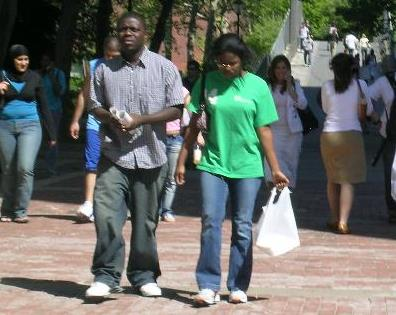

In [26]:
Image.fromarray(img.mul(255).permute(1,2,0).byte().numpy())

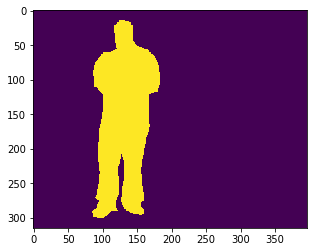

In [27]:
plt.imshow(Image.fromarray(tar['masks'][0].mul(255).byte().numpy()))
M = tar['masks'].size()[0]


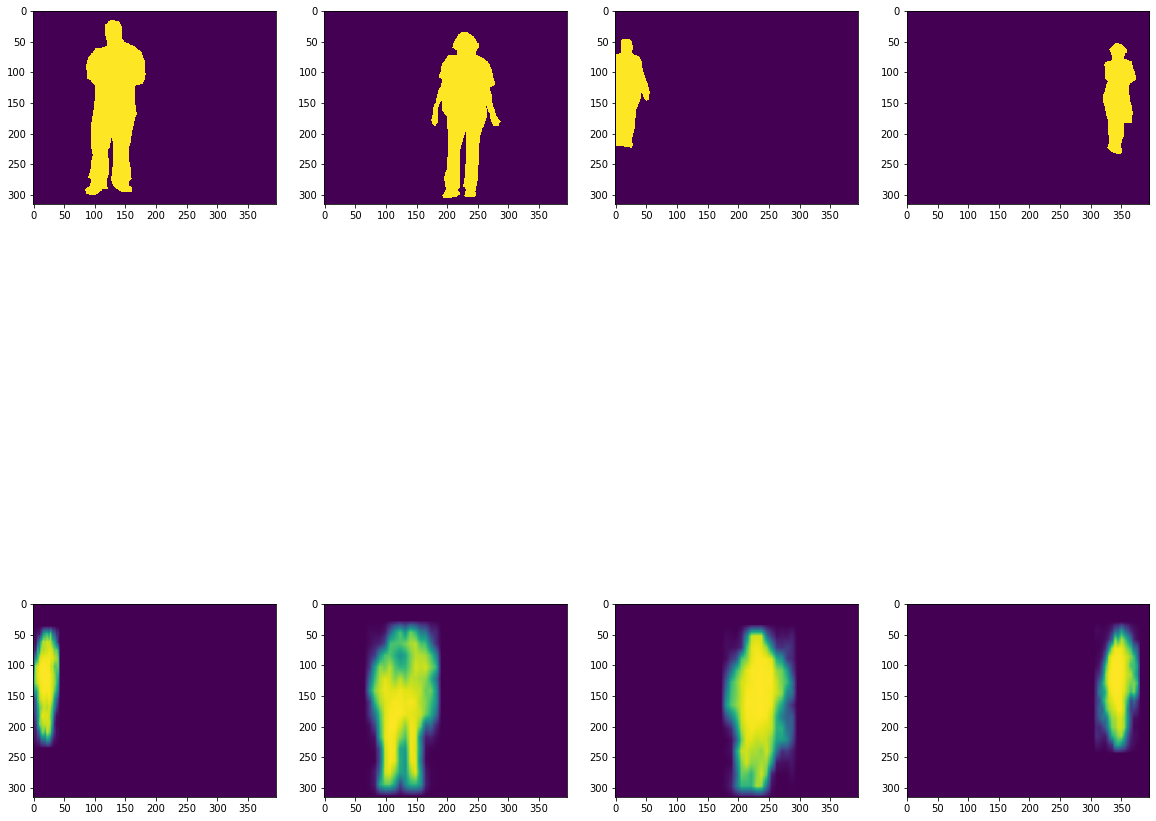

In [28]:
fig, (axs1, axs2) = plt.subplots(2,M,figsize= (20,20))
for i in range(M):
  axs1[i].imshow(Image.fromarray(tar['masks'][i].mul(255).byte().numpy()))
  axs2[i].imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))

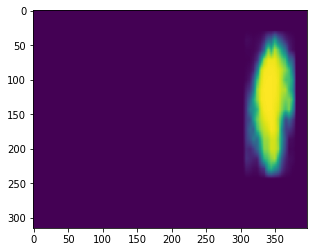

In [29]:
plt.imshow(Image.fromarray(prediction[0]['masks'][3, 0].mul(255).byte().cpu().numpy()))